**Import libraries**


In [24]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

**Mounth Path**


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Define Dataset Path**

In [26]:
data_path = '/content/drive/MyDrive/cvpr/Animals'

**check the categories**

In [27]:
catagories = []
for c in os.listdir(data_path):
    catagories.append(c)
print(catagories)

['Jaguar', 'Tiger', 'Cheetah', 'Lion', 'Leopard']


**Data Loading and Preprocessing**

100%|██████████| 31/31 [00:00<00:00, 70.37it/s]


170


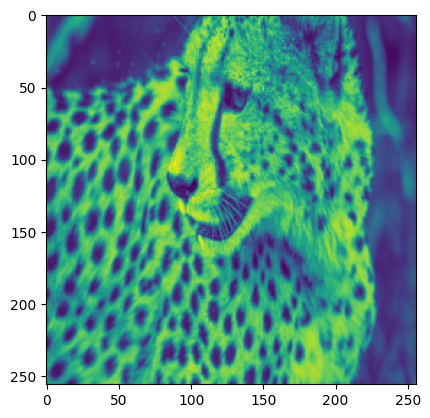

In [28]:
data = []
for c in catagories:
  path = os.path.join(data_path, c)
  class_num = catagories.index(c)
  for img in tqdm(os.listdir(path)):
    img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
    img_arr = cv.resize(img_arr, (256, 256), interpolation=cv.INTER_AREA)
    plt.imshow(img_arr)
    data.append([img_arr, class_num])

print(len(data))

**Image Shuffling**


In [29]:
random.shuffle(data)

**Dataset visualization**

showing the first 50 images with their labels.


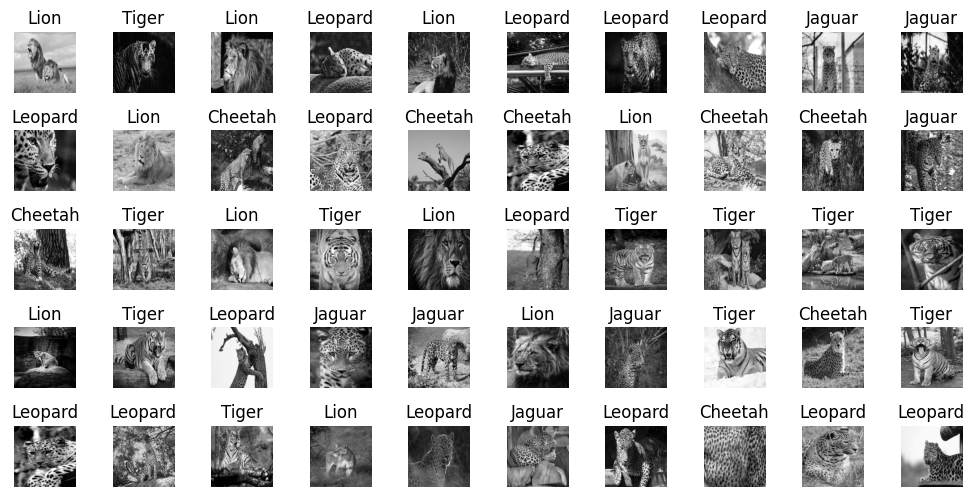

In [30]:
plt.figure(figsize=(10, 10))

for i in range(50):
  plt.subplot(10, 10, i+1)
  plt.imshow(data[i][0], cmap='gray')
  plt.title(catagories[data[i][1]])
  plt.axis('off')

plt.tight_layout()
plt.show()

**Dataset Splitting**

In [31]:
f1 = data[0:20]
f2 = data[20:40]
f3 = data[40:60]
f4 = data[60:80]
f5 = data[80:100]

**Calculation L2 Distance (Euclidean Distance)**


In [32]:
def calc_l2_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

**Distance Calculation**

In [33]:
k_max = 30

def calc_distance(train, val):
    l2_result = []
    for v in tqdm(val):
        temp = []
        for t in train:
            temp.append([v[1], t[1], calc_l2_distance(v[0], t[0])])
        temp.sort(key=lambda x: x[2])
        l2_result.append(temp[:k_max])
    return l2_result


**K-NN Accuracy Calculation**

In [34]:
k_max = 30
def calc_accuracy(distance_val, distance_label):
    k_acc = []
    for k in range(1, k_max+1):
        img_acc = 0

        for img_dist in distance_val:
            top_k = img_dist[:k]

            same_class_img = [t_k for t_k in top_k if t_k[0] == t_k[1]]

            if k % 2 != 0:
                if (k // 2) < len(same_class_img):
                    img_acc += 1
            else:
                diff_class_img = [t_k for t_k in top_k if t_k[0] != t_k[1]]
                if len(same_class_img) > len(diff_class_img):
                    img_acc += 1
                elif len(same_class_img) == len(diff_class_img):
                    same_class_dist = sum([s_c[2][distance_label] for s_c in same_class_img])
                    diff_class_dist = sum([d_c[2][distance_label] for d_c in diff_class_img])
                    if same_class_dist > diff_class_dist:
                        img_acc += 1

        k_acc.append(img_acc/len(distance_val))
    return k_acc





**K-Fold Cross-Validation**

In [35]:
fold_distance = []

for i in range(1, 6):
    if i == 1:
        train, validation = f1 + f2 + f3 + f4, f5
    elif i == 2:
        train, validation = f1 + f2 + f3 + f5, f4
    elif i == 3:
        train, validation = f1 + f2 + f4 + f5, f3
    elif i == 4:
        train, validation = f1 + f3 + f4 + f5, f2
    elif i == 5:
        train, validation = f2 + f3 + f4 + f5, f1

    fold_distance.append(calc_distance(train, validation))

len(fold_distance[0][0])


100%|██████████| 20/20 [00:00<00:00, 168.81it/s]


30

**K-Fold Accuracy Calculation**

In [36]:
def calc_accuracy(distance_val):
    k_acc = []
    for k in range(1, k_max + 1):
        img_acc = 0
        for img_dist in distance_val:
            top_k = img_dist[:k]
            same_class = [t_k for t_k in top_k if t_k[0] == t_k[1]]
            if len(same_class) > k // 2:
                img_acc += 1
        k_acc.append(img_acc / len(distance_val))
    return k_acc

accuracies = [calc_accuracy(fold) for fold in fold_distance]
for i in accuracies:
  print(i)

[0.25, 0.1, 0.2, 0.1, 0.15, 0.05, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.35, 0.05, 0.15, 0.05, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.35, 0.1, 0.15, 0.1, 0.15, 0.05, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.25, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.1, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.25, 0.05, 0.2, 0.05, 0.15, 0.05, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


**Visualization of K-NN Accuracy**



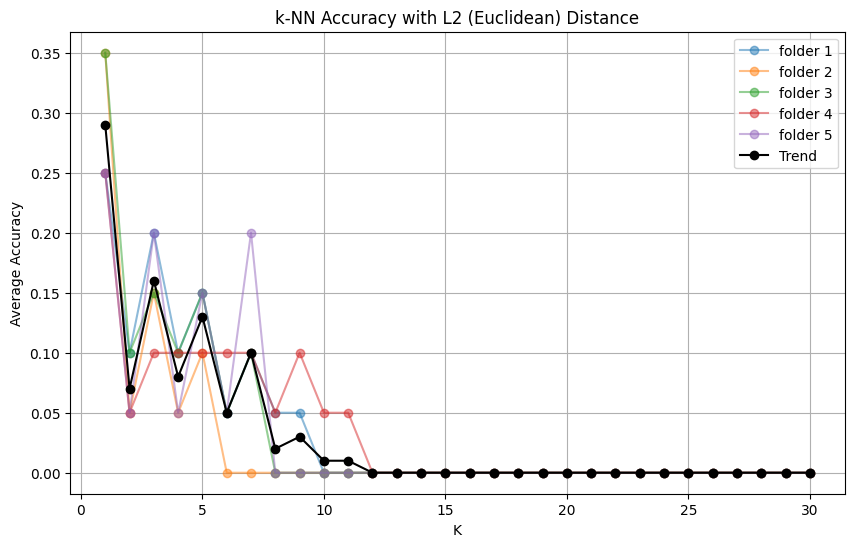

In [37]:
x_list = list(range(1, k_max + 1))
cl=0

plt.figure(figsize=(10, 6))
for fold in accuracies:
    plt.plot(x_list, fold,'o-', label=f'folder {cl+1}', alpha=0.5)
    cl+=1
trend = [np.mean([fold[k] for fold in accuracies]) for k in range(k_max)]
plt.plot(x_list, trend,'o-',color='black', label='Trend')
plt.title('k-NN Accuracy with L2 (Euclidean) Distance')
plt.xlabel('K')
plt.ylabel('Average Accuracy')
plt.legend()
plt.grid()
plt.show()